# Palm Kernal Sales Classification Tuning


In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/cargill/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/cargill/
/content/gdrive/My Drive/cargill


In [2]:
#pip install lightgbm==2.3.0 #the older version causes colab kernel to crash

     |████████████████████████████████| 1.3 MB 9.5 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import create_prediction_df as prep # custom function that calls both of the below to create prediction df
# import futures_preprocessing_monthly as fp # custom functions to clean futures data, call fp.preprocess
# import customer_features_monthly as cf # custom functions for customer features

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

# Pipeline
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

# Models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Formatting
from sklearn import set_config
set_config(display="diagram")

# Scoring
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

## 1. Define Helper Functions

In [4]:
def change_dtypes(df):
    df['month'] = df['month'].astype(str)
    df['quarter'] = df['quarter'].astype(str)

    # Change sentiment to categorical variable
    # for col in df.columns:
    #     if col.find('sentiment') != -1:
    #         df[col] = df[col].astype(str)

    return df

# Define helper function
def fit_and_predict(model, X_train, X_test, y_train, y_test, verbose = True):
    model.fit(X_train, np.ravel(y_train))
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    train_f1 = f1_score(y_train, y_train_pred, pos_label=1)
    train_precision = precision_score(y_train, y_train_pred, pos_label=1)
    train_recall = recall_score(y_train, y_train_pred, pos_label=1)
    
    test_f1 = f1_score(y_test, y_test_pred, pos_label=1)
    test_precision = precision_score(y_test, y_test_pred, pos_label=1)
    test_recall = recall_score(y_test, y_test_pred, pos_label=1)

    print('Train f1 score: ', train_f1)
    print("Train precision: ", train_precision)
    print("Train recall: ", train_recall)

    print('Test f1 score: ', test_f1)
    print("Test precision: ", test_precision)
    print("Test recall: ", test_recall)
        
    return model

# Calls stratified KFold by default
def cross_validate_scores(name, model, X, y):
    score = cross_validate(model, X, y, scoring=['f1', 'precision', 'recall'], verbose=0, cv = 3) # 3 rounds to save time
    
    print('----{}----'.format(name))
    print('Mean 3-fold cross val f1 score: {:3f}'.format(np.mean(score['test_f1'])))
    print('Mean 3-fold cross val precision: {:3f}'.format(np.mean(score['test_precision'])))
    print('Mean 3-fold cross val recall: {:3f}'.format(np.mean(score['test_recall'])))

def feature_importance_with_pipe(pipeline, numeric_col, cat_col):
    all_features = list(numeric_col)+list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(cat_col))
    importances = pd.DataFrame(pipeline[-1].feature_importances_, columns=['weights'], index = pipeline[-2].get_feature_names_out(all_features))
    importances = importances.sort_values('weights', ascending = False)
    importances_subset = importances.iloc[0:15, :]
    plt.figure(figsize = (15, 10))
    plt.title('Feature Importances')
    plt.ylabel('Features')
    plt.xlabel('Importances')
    sns.barplot(x = importances_subset['weights'], y = importances_subset.index)
    plt.show()
    
    return importances

In [5]:
def random_search_pipe(model_pipe, grid, X_train, y_train):
    
#    search = RandomizedSearchCV(model_pipe, grid, cv=3, n_jobs=-1, scoring='f1', n_iter = 200, verbose = 10)
    search = RandomizedSearchCV(model_pipe, grid, cv=3, scoring='f1', n_iter = 200, verbose = 10) #remove n_jobs = -1 for colab
    search.fit(X_train, y_train)
    
    print("Best params: {}".format(search.best_params_))
    print("Best mean CV score: {}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    print("Train score: ", search.score(X_train,np.ravel(y_train)))
    print("Test score: ", search.score(X_test,np.ravel(y_test)))
    
    return search

In [33]:
def grid_search_pipe(model_pipe, grid, X_train, y_train):
    
#    search = GridSearchCV(model_pipe, grid, cv=5, n_jobs=-1, scoring='f1')
    search = GridSearchCV(model_pipe, grid, cv=5, scoring='f1') #remove n_jobs = -1 for colab
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    print("Train score: ", search.score(X_train,np.ravel(y_train)))
    print("Test score: ", search.score(X_test,np.ravel(y_test)))
    
    return search

## 1.1 Prepare Prediction Data

In [78]:
# SET ALL PARAMS HERE
# Random state
random_state = 42

# Oils
oil = 'PALM KERNEL OIL'# Set oil type
oil_file = 'data/palmkernaloil_futures.csv'
remove_scenario = 'purchase' # if you want to predict sales, remove purchase. if predicting purchase, remove sales.
first_date = '2018-01-01' # Get data up to this date for prediction
last_date = '2022-01-01' # Last date at which customer data will cut off, default first_date = '2020-01-01'

# Set futures lookback params
ema_lookback = [2] # 1 month and 2 months
pct_lookback = [2] # 1 month and 2 months
adv_months_list = [2] # futures to look at (in months) e.g. look at the contract 2 and 4 months from now

# Set lag variable params
lag = 2 # Set lag time, 2 = prediction for 2 months
lags_by_variable = {'cust_lag': [lag],
                   'oil_lag': [lag],
                   'fx_lag': [lag],
                   'sentiment_lag': [lag]} # all lags must be greater than initial lag period

# Sentiment cols_to_keep
sentiment_cols = ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']

In [79]:
# Generate customer df
all_cust_monthly_df = prep.get_lagged_customer_df(oil = oil, 
                                                  first_date = first_date, 
                                                  last_date = last_date, 
                                                  lags_by_variable = lags_by_variable, 
                                                  verbose = False)

# Generate oils and fx dfs
oils_df, crude_df, fx_df = prep.get_lagged_futures_df(oil_file = oil_file, 
                                                      first_date = first_date, 
                                                      last_date = last_date, 
                                                      lags_by_variable = lags_by_variable,
                                                      ema_lookback = ema_lookback,
                                                      pct_lookback = pct_lookback,
                                                      adv_months_list = adv_months_list,
                                                      verbose = False)

# Generate monthly sentiment df
sentiment = prep.get_sentiment_df(lags_by_variable = lags_by_variable, 
                                  cols_to_keep = sentiment_cols, 
                                  verbose = False)

# Merge all dfs
combined_df = prep.merge_dfs(all_cust_monthly_df = all_cust_monthly_df, 
                             remove_scenario = remove_scenario, 
                             oils_df = oils_df, 
                             crude_df = crude_df, 
                             fx_df = fx_df, 
                             sentiment_df = sentiment, 
                             verbose = True)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-2)_cust', 'purchases_on_month(t-2)_cust', 'purchase_quantity_on_month(t-2)_cust', 'cumulative_purchases_till_month(t-2)_cust', 'purchase_frequency(t-2)_cust', 'purchase_frequency_over_year(t-2)_cust', 'purchase_frequency_over_quarter(t-2)_cust', 'months_since_purchase(t-2)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00


In [80]:
# Keep columes with 'lag'
pred = combined_df.copy()

# Remove columns unrelated to prediction
remove = [v for v in pred.columns if 'volume' in v] + [v for v in pred.columns if 'ema' in v] + [v for v in pred.columns if 'openinterest' in v]

print(remove)                                                                            
other_cols = ['date'] + remove
pred = pred.drop(other_cols, axis = 1)

# Drop na
pred = pred.replace([np.inf, -np.inf], 0)

# pred.info()
print('Length before dropping na (lag rows): {}'.format(len(pred)))

pred = pred.dropna() # remove lag empty rows
print('Length after dropping na (lag rows): {}'.format(len(pred)))

# # Change data types
pred = change_dtypes(pred)

['2m_volume(t-2)_oils', '2m_volume_ema_2m(t-2)_oils', '2m_volume_pctgrowth_2m(t-2)_oils', '2m_volume(t-2)_crude', '2m_volume_ema_2m(t-2)_crude', '2m_volume_pctgrowth_2m(t-2)_crude', '2m_volume(t-2)_fx', '2m_volume_ema_2m(t-2)_fx', '2m_volume_pctgrowth_2m(t-2)_fx', '2m_close_ema_2m(t-2)_oils', '2m_volume_ema_2m(t-2)_oils', '2m_openinterest_ema_2m(t-2)_oils', '2m_close_ema_2m(t-2)_crude', '2m_volume_ema_2m(t-2)_crude', '2m_openinterest_ema_2m(t-2)_crude', '2m_close_ema_2m(t-2)_fx', '2m_volume_ema_2m(t-2)_fx', '2m_openinterest_ema_2m(t-2)_fx', '2m_openinterest(t-2)_oils', '2m_openinterest_ema_2m(t-2)_oils', '2m_openinterest_pctgrowth_2m(t-2)_oils', '2m_openinterest(t-2)_crude', '2m_openinterest_ema_2m(t-2)_crude', '2m_openinterest_pctgrowth_2m(t-2)_crude', '2m_openinterest(t-2)_fx', '2m_openinterest_ema_2m(t-2)_fx', '2m_openinterest_pctgrowth_2m(t-2)_fx']
Length before dropping na (lag rows): 19200
Length after dropping na (lag rows): 17600


In [81]:
pred.columns

Index(['month', 'quarter', '%sales_on_month', '%sales_on_month_lag_2',
       'sale(t-2)_cust', 'sales_on_month(t-2)_cust',
       'sales_quantity_on_month(t-2)_cust',
       'cumulative_sales_till_month(t-2)_cust', 'sales_frequency(t-2)_cust',
       'sales_frequency_over_year(t-2)_cust',
       'sales_frequency_over_quarter(t-2)_cust', 'months_since_sale(t-2)_cust',
       'sale', 'sales_on_month', '2m_close(t-2)_oils',
       '2m_close_pctgrowth_2m(t-2)_oils', '2m_close(t-2)_crude',
       '2m_close_pctgrowth_2m(t-2)_crude', '2m_close(t-2)_fx',
       '2m_close_pctgrowth_2m(t-2)_fx', 'crude oil(t-2)_sentiment',
       'crude oil_Count(t-2)_sentiment', 'palm oil(t-2)_sentiment',
       'palm oil_Count(t-2)_sentiment'],
      dtype='object')

## 1.2 Set up Pipeline

In [82]:
# Define Train-Test split
Y = pred['sale'].astype(int)
X = pred.drop(['sale', 'sales_on_month', 'sales_frequency(t-2)_cust'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

In [83]:
X_train.columns

Index(['month', 'quarter', '%sales_on_month', '%sales_on_month_lag_2',
       'sale(t-2)_cust', 'sales_on_month(t-2)_cust',
       'sales_quantity_on_month(t-2)_cust',
       'cumulative_sales_till_month(t-2)_cust',
       'sales_frequency_over_year(t-2)_cust',
       'sales_frequency_over_quarter(t-2)_cust', 'months_since_sale(t-2)_cust',
       '2m_close(t-2)_oils', '2m_close_pctgrowth_2m(t-2)_oils',
       '2m_close(t-2)_crude', '2m_close_pctgrowth_2m(t-2)_crude',
       '2m_close(t-2)_fx', '2m_close_pctgrowth_2m(t-2)_fx',
       'crude oil(t-2)_sentiment', 'crude oil_Count(t-2)_sentiment',
       'palm oil(t-2)_sentiment', 'palm oil_Count(t-2)_sentiment'],
      dtype='object')

0    15621
1     1979
Name: sale, dtype: int64


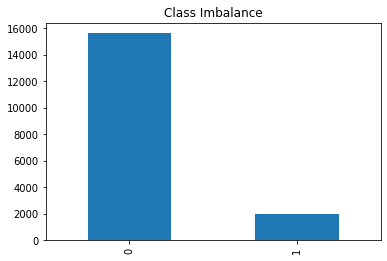

In [84]:
Y.value_counts().plot(kind='bar')

print(Y.value_counts())
plt.title('Class Imbalance')
plt.show()

In [85]:
# Define Pre-processing pipeline
numeric_col = X.select_dtypes(include=np.number).columns
cat_col = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_col ),
        ("cat", OneHotEncoder(sparse=False), cat_col),
    ]
    , remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 Index(['%sales_on_month', '%sales_on_month_lag_2', 'sale(t-2)_cust',
       'sales_on_month(t-2)_cust', 'sales_quantity_on_month(t-2)_cust',
       'cumulative_sales_till_month(t-2)_cust',
       'sales_frequency_over_year(t-2)_cust',
       'sales_frequency_over_quarter(t-2)_cust', 'months_since_sale(t-2...
       '2m_close(t-2)_oils', '2m_close_pctgrowth_2m(t-2)_oils',
       '2m_close(t-2)_crude', '2m_close_pctgrowth_2m(t-2)_crude',
       '2m_close(t-2)_fx', '2m_close_pctgrowth_2m(t-2)_fx',
       'crude oil(t-2)_sentiment', 'crude oil_Count(t-2)_sentiment',
       'palm oil(t-2)_sentiment', 'palm oil_Count(t-2)_sentiment'],
      dtype='object')),
                                ('cat', OneHotEncoder(sparse=False),
                                 Index(['month', 'quarter'], dtype='object'))])

# 2. Wrap Section 1 in Function

In [86]:
def get_train_test_split(lag, oil, oil_file, first_date, last_date, ema_lookback, pct_lookback, adv_months_list, cols_to_keep):
       # Set lag variable params
    lags_by_variable = {'cust_lag': [lag],
                       'oil_lag': [lag],
                       'fx_lag': [lag],
                       'sentiment_lag': [lag]} # all lags must be greater than initial lag period

    # Generate df
    # Generate customer df
    all_cust_monthly_df = prep.get_lagged_customer_df(oil = oil, 
                                                      first_date = first_date, 
                                                      last_date = last_date, 
                                                      lags_by_variable = lags_by_variable, 
                                                      verbose = False)

    # Generate oils and fx dfs
    oils_df, crude_df, fx_df = prep.get_lagged_futures_df(oil_file = oil_file, 
                                                          first_date = first_date, 
                                                          last_date = last_date, 
                                                          lags_by_variable = lags_by_variable,
                                                          ema_lookback = ema_lookback,
                                                          pct_lookback = pct_lookback,
                                                          adv_months_list = adv_months_list,
                                                          verbose = False)

    # Generate monthly sentiment df
    sentiment = prep.get_sentiment_df(lags_by_variable = lags_by_variable, 
                                      cols_to_keep = sentiment_cols, 
                                      verbose = False)

    # Merge all dfs
    combined_df = prep.merge_dfs(all_cust_monthly_df = all_cust_monthly_df, 
                                 remove_scenario = remove_scenario, 
                                 oils_df = oils_df, 
                                 crude_df = crude_df, 
                                 fx_df = fx_df, 
                                 sentiment_df = sentiment, 
                                 verbose = True)

    # Prediction prep
    # Keep columes with 'lag'
    pred = combined_df.copy()

    # Remove columns unrelated to prediction
    remove =  [v for v in pred.columns if 'volume' in v] + [v for v in pred.columns if 'ema' in v] + [v for v in pred.columns if 'openinterest' in v] 
    other_cols = ['date'] + remove
    pred = pred.drop(other_cols, axis = 1)

    # Drop na
    pred = pred.replace([np.inf, -np.inf], 0)

    # pred.info()
    print('Length before dropping na (lag rows): {}'.format(len(pred)))

    pred = pred.dropna() # remove lag empty rows
    print('Length after dropping na (lag rows): {}'.format(len(pred)))

    # # Change data types
    pred = change_dtypes(pred)
    
    # Define Train-Test split
    Y = pred['sale'].astype(int)
    cols_to_drop = ['sale', 'sales_on_month'] # remove highly correlated features manually
    X = pred.drop(cols_to_drop, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

# 3. Models

## 3.1 Define Benchmark: Logistic Regression

In [24]:
# logreg baseline pipe
pipe_lr = Pipeline([("preprocessor", preprocessor),('oversample', SMOTETomek()), 
                 ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), ('predict', LogisticRegression(C = 0.001))], verbose=False)

lr = fit_and_predict(model = pipe_lr, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Train f1 score:  0.4484304932735426
Train precision:  0.3302311618132693
Train recall:  0.6984126984126984
Test f1 score:  0.4471153846153846
Test precision:  0.3305687203791469
Test recall:  0.6905940594059405


In [34]:
# Tuning
# Grid Search

# Without feature selection
pipe_lr = Pipeline([("preprocessor", preprocessor),
                      ('classifier', LogisticRegression())], verbose=False) 

param_grid = [
    {
        "classifier":[LogisticRegression()],
        'preprocessor__num':[StandardScaler(),RobustScaler()],
        "classifier__C": [0.001, 0.01, 0.1, 1],
        "classifier__class_weight": [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}]
    }
]

search = grid_search_pipe(model_pipe = pipe_lr, grid = param_grid, X_train = X_train, y_train = y_train)

Best params:
{'classifier': LogisticRegression(C=1, class_weight={0: 1, 1: 4}), 'classifier__C': 1, 'classifier__class_weight': {0: 1, 1: 4}, 'preprocessor__num': StandardScaler()}
Best score:
0.4744140569098062
Train score:  0.4780853517877739
Test score:  0.46085011185682334


In [36]:
print('TUNED')
pipe_lr_tuned = Pipeline([("preprocessor", preprocessor),
                      ('predict', LogisticRegression(C=1, class_weight={0: 1, 1: 4}) 
                      )], verbose=10)

pipe_lr_tuned

model = fit_and_predict(model = pipe_lr_tuned, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

TUNED
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing predict, total=   0.7s
Train f1 score:  0.4780853517877739
Train precision:  0.43792921288959324
Train recall:  0.5263492063492063
Test f1 score:  0.46085011185682334
Test precision:  0.4204081632653061
Test recall:  0.5099009900990099


### Check Robustness Over Time

In [43]:
def check_accuracy_dropoff_lr(name, tuned_model, X_train, y_train, X_test, y_test):

    # Set up pipeline 
    numeric_col = X_train.select_dtypes(include=np.number).columns
    cat_col = X_train.select_dtypes(include='object').columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_col ),
            ("cat", OneHotEncoder(sparse=False), cat_col),
        ]
        , remainder='passthrough'
    )
    ##### THIS IS THE ONLY PART THAT IS DIFFERENT ###########
    # Set up pipeline
    pipeline = Pipeline([("preprocessor", preprocessor), 
                         ('predict', tuned_model #Using result from rapeseed oil best params
                      )], verbose=False)

    
    fitted_model = fit_and_predict(model = pipeline, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    cross_validate_scores(name, fitted_model, X_train, y_train)

    return fitted_model

In [44]:
tuned_lr = LogisticRegression(C=1, class_weight={0: 1, 1: 4})

In [45]:
# Check different lags

X_train, X_test, y_train, y_test = get_train_test_split(lag = 1, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lr_lag1 = check_accuracy_dropoff_lr(name = 'LRclf_1M_Lag', 
                                        tuned_model = tuned_lr,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-1)_cust', 'purchases_on_month(t-1)_cust', 'purchase_quantity_on_month(t-1)_cust', 'cumulative_purchases_till_month(t-1)_cust', 'purchase_frequency(t-1)_cust', 'purchase_frequency_over_year(t-1)_cust', 'purchase_frequency_over_quarter(t-1)_cust', 'months_since_purchase(t-1)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [46]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 2, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lr_lag2 = check_accuracy_dropoff_lr(name = 'LRclf_2M_Lag', 
                                        tuned_model = tuned_lr,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-2)_cust', 'purchases_on_month(t-2)_cust', 'purchase_quantity_on_month(t-2)_cust', 'cumulative_purchases_till_month(t-2)_cust', 'purchase_frequency(t-2)_cust', 'purchase_frequency_over_year(t-2)_cust', 'purchase_frequency_over_quarter(t-2)_cust', 'months_since_purchase(t-2)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [47]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 3, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lr_lag3 = check_accuracy_dropoff_lr(name = 'LRclf_3M_Lag', 
                                        tuned_model = tuned_lr,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-3)_cust', 'purchases_on_month(t-3)_cust', 'purchase_quantity_on_month(t-3)_cust', 'cumulative_purchases_till_month(t-3)_cust', 'purchase_frequency(t-3)_cust', 'purchase_frequency_over_year(t-3)_cust', 'purchase_frequency_over_quarter(t-3)_cust', 'months_since_purchase(t-3)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [48]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 6, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lr_lag6 = check_accuracy_dropoff_lr(name = 'LRclf_6M_Lag', 
                                        tuned_model = tuned_lr,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-6)_cust', 'purchases_on_month(t-6)_cust', 'purchase_quantity_on_month(t-6)_cust', 'cumulative_purchases_till_month(t-6)_cust', 'purchase_frequency(t-6)_cust', 'purchase_frequency_over_year(t-6)_cust', 'purchase_frequency_over_quarter(t-6)_cust', 'months_since_purchase(t-6)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

## 3.2 LightGBM + No Over/Under

### Baseline

In [59]:
# Get a baseline. 

print('Baseline: NO TUNING, NO FEATURE SELECTION')

# With feature select: score is slightly lower
# pipe_lgbm = Pipeline([("preprocessor", preprocessor),('feature_selection', SelectFromModel(lgb.LGBMClassifier(device_type = 'gpu', verbosity = 0), threshold='median')), 
#                       ('predict', lgb.LGBMClassifier(device_type = 'gpu', verbosity = 0))], verbose=10)

# Without feature selection
pipe_lgbm = Pipeline([("preprocessor", preprocessor),
                      ('classifier', lgb.LGBMClassifier(device_type = 'cpu', verbosity = 0))], verbose=10) # change to device_type = 'cpu' to run on local

model = fit_and_predict(model = pipe_lgbm, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Baseline: NO TUNING, NO FEATURE SELECTION
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
Train f1 score:  0.6125587355830842
Train precision:  0.9360313315926893
Train recall:  0.4552380952380952
Test f1 score:  0.35494880546075086
Test precision:  0.5714285714285714
Test recall:  0.25742574257425743


### Tune LightGBM

In [64]:
# WARNING: SLOW, DO NOT RERUN!
# Wide Random Search
# Without feature selection
pipe_lgbm = Pipeline([("preprocessor", preprocessor),
                      ('classifier', lgb.LGBMClassifier(device_type = 'cpu', verbosity = 0))], verbose=False) # change to device_type = 'cpu' to run on local

param_grid = [
    {
        "classifier":[lgb.LGBMClassifier(colsample_bytree=0.8, subsample=0.8, learning_rate=0.1, random_state = random_state)],
        'preprocessor__num':[StandardScaler(),RobustScaler()],
        "classifier__n_estimators": range(50, 500, 50), # Important
        "classifier__max_depth": range(2,20,2),
        'classifier__max_bin': range(2, 20, 2),
        'classifier__subsample': np.linspace(0.3, 1, 10),
        'classifier__colsample_bytree': np.linspace(0.5, 1, 5),
        'classifier__scale_pos_weight': range(1, 10, 2), # Important
        'classifier__num_leaves': range(10, 200, 10)
    },
]

search = random_search_pipe(model_pipe = pipe_lgbm, grid = param_grid, X_train = X_train, y_train = y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START classifier=LGBMClassifier(colsample_bytree=0.8, random_state=42, subsample=0.8), classifier__colsample_bytree=0.625, classifier__max_bin=18, classifier__max_depth=4, classifier__n_estimators=150, classifier__num_leaves=110, classifier__scale_pos_weight=1, classifier__subsample=0.6888888888888889, preprocessor__num=StandardScaler()
[CV 1/3; 1/200] END classifier=LGBMClassifier(colsample_bytree=0.8, random_state=42, subsample=0.8), classifier__colsample_bytree=0.625, classifier__max_bin=18, classifier__max_depth=4, classifier__n_estimators=150, classifier__num_leaves=110, classifier__scale_pos_weight=1, classifier__subsample=0.6888888888888889, preprocessor__num=StandardScaler();, score=0.374 total time=   1.8s
[CV 2/3; 1/200] START classifier=LGBMClassifier(colsample_bytree=0.8, random_state=42, subsample=0.8), classifier__colsample_bytree=0.625, classifier__max_bin=18, classifier__max_depth=4, classifi

In [65]:
def get_cv_scores(pipeline, X_train, y_train):
    score = cross_validate(pipeline, X_train, y_train, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0, cv = 3) # 3 rounds to save time
    results = {
               'test_f1': np.mean(score['test_f1']), 
               'test_precision': np.mean(score['test_precision']), 
               'test_recall': np.mean(score['test_recall'])}
    
    return results

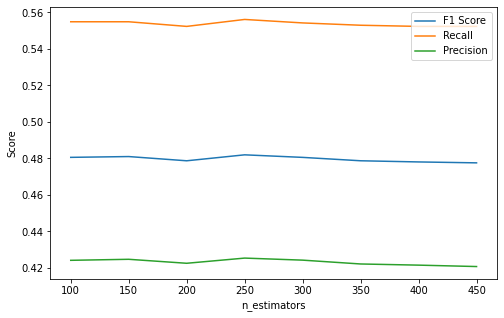

In [66]:
#. Inspecting n_estimators
validation_f1 = [] # you need to clean the array if you restart
validation_recall = [] # you need to clean the array if you restart
validation_precision= [] # you need to clean the array if you restart
settings = list(range(100, 500, 50)) # range of parameters to explore

for n_est in settings:
    # build the model
    pipe_lgbm_plot = Pipeline([("preprocessor", preprocessor), 
                      ('predict', lgb.LGBMClassifier(n_estimators = n_est,
                                                     max_depth = 2, 
                                                     max_bin = 4,
                                                     subsample = 0.85, 
                                                     colsample_bytree = 0.75,
                                                     scale_pos_weight = 3,
                                                     num_leaves = 80,
                                                     importance_type = 'gain',
                                                     random_state = random_state) # total gain of splits using the feature
                      )], verbose=10)

    # build model
    results = get_cv_scores(pipe_lgbm_plot, X_train = X_train, y_train = y_train)
    
    # record validation set auc
    validation_f1.append(results['test_f1'])
    validation_recall.append(results['test_recall'])
    validation_precision.append(results['test_precision'])

plt.figure(figsize = (8,5))

plt.plot(settings, validation_f1, label="F1 Score")
plt.plot(settings, validation_recall, label="Recall")
plt.plot(settings, validation_precision, label="Precision")
plt.ylabel("Score")
plt.ylabel("Score")
plt.xlabel("n_estimators")
plt.legend()

plt.show()

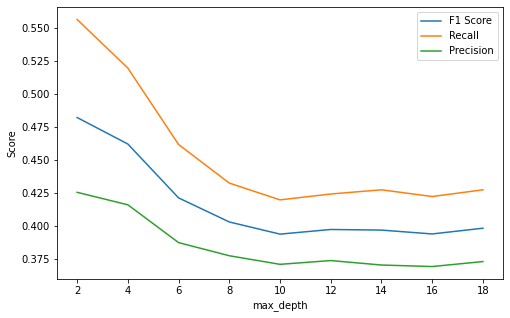

In [67]:
# Inspecting max_depth

validation_f1 = [] # you need to clean the array if you restart
validation_recall = [] # you need to clean the array if you restart
validation_precision= [] # you need to clean the array if you restart
settings = list(range(2, 20, 2)) # range of parameters to explore


for est in settings:
    # build the model
    pipe_lgbm_plot = Pipeline([("preprocessor", preprocessor), 
                      ('predict', lgb.LGBMClassifier(n_estimators = 250,
                                                     max_depth = est, 
                                                     max_bin = 4,
                                                     subsample = 0.85, 
                                                     colsample_bytree = 0.75,
                                                     scale_pos_weight = 3,
                                                     num_leaves = 80,
                                                     importance_type = 'gain',
                                                     random_state = random_state) # total gain of splits using the feature
                      )], verbose=10)

    # build model
    results = get_cv_scores(pipe_lgbm_plot, X_train = X_train, y_train = y_train)
    
    # record validation set auc
    validation_f1.append(results['test_f1'])
    validation_recall.append(results['test_recall'])
    validation_precision.append(results['test_precision'])

plt.figure(figsize = (8,5))

plt.plot(settings, validation_f1, label="F1 Score")
plt.plot(settings, validation_recall, label="Recall")
plt.plot(settings, validation_precision, label="Precision")
plt.ylabel("Score")
plt.ylabel("Score")
plt.xlabel("max_depth")
plt.legend()

plt.show()

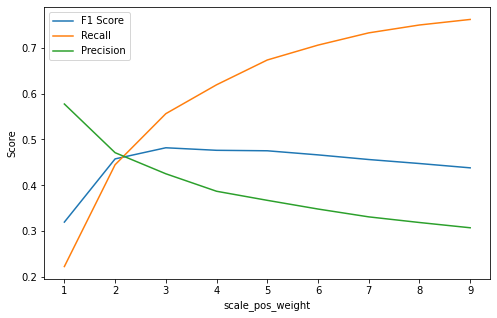

In [68]:
# Inspecting scale_post_weight

validation_f1 = [] # you need to clean the array if you restart
validation_recall = [] # you need to clean the array if you restart
validation_precision= [] # you need to clean the array if you restart
settings = list(range(1, 10, 1)) # range of parameters to explore

for est in settings:
    # build the model
    pipe_lgbm_plot = Pipeline([("preprocessor", preprocessor), 
                      ('predict', lgb.LGBMClassifier(n_estimators = 250,
                                                     max_depth = 2, 
                                                     max_bin = 4,
                                                     subsample = 0.85, 
                                                     colsample_bytree = 0.75,
                                                     scale_pos_weight = est,
                                                     num_leaves = 80,
                                                     importance_type = 'gain',
                                                     random_state = random_state) # total gain of splits using the feature
                      )], verbose=False)

    # build model
    results = get_cv_scores(pipe_lgbm_plot, X_train = X_train, y_train = y_train)
    
    # record validation set auc
    validation_f1.append(results['test_f1'])
    validation_recall.append(results['test_recall'])
    validation_precision.append(results['test_precision'])

plt.figure(figsize = (8,5))

plt.plot(settings, validation_f1, label="F1 Score")
plt.plot(settings, validation_recall, label="Recall")
plt.plot(settings, validation_precision, label="Precision")
plt.ylabel("Score")
plt.ylabel("Score")
plt.xlabel("scale_pos_weight")
plt.legend()

plt.show()

### Best LightGBM Model

In [69]:
# Best Model
# Note that test outperforms train?
print('TUNED')
pipe_lgbm_tuned = Pipeline([("preprocessor", preprocessor), # set threshold = 0 to turn off feature selection
                      ('predict', lgb.LGBMClassifier(n_estimators = 250,
                                                     max_depth = 2, 
                                                     max_bin = 4,
                                                     subsample = 0.85, 
                                                     colsample_bytree = 0.75,
                                                     scale_pos_weight = 2.2,
                                                     num_leaves = 80,
                                                     importance_type = 'gain',
                                                     random_state = random_state) # total gain of splits using the feature
                      )], verbose=10)

pipe_lgbm_tuned

lgbm_no_selection = fit_and_predict(model = pipe_lgbm_tuned, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

TUNED
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing predict, total=   0.7s
Train f1 score:  0.4853399875233936
Train precision:  0.47700797057020233
Train recall:  0.49396825396825395
Test f1 score:  0.46380368098159513
Test precision:  0.45985401459854014
Test recall:  0.46782178217821785


In [70]:
# # Best Model: No difference with or without feature selection

print('TUNED')
pipe_lgbm_tuned = Pipeline([("preprocessor", preprocessor), ('feature_selection', SelectFromModel(lgb.LGBMClassifier(), threshold=0)), # set threshold = 0 to turn off feature selection
                      ('predict', lgb.LGBMClassifier(n_estimators = 250,
                                                     max_depth = 2, 
                                                     max_bin = 4,
                                                     subsample = 0.85, 
                                                     colsample_bytree = 0.75,
                                                     scale_pos_weight = 2.2,
                                                     num_leaves = 80,
                                                     importance_type = 'gain',
                                                     random_state = random_state) # total gain of splits using the feature
                      )], verbose=10)

pipe_lgbm_tuned

lgbm_selection = fit_and_predict(model = pipe_lgbm_tuned, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

TUNED
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.4s
[Pipeline] ........... (step 3 of 3) Processing predict, total=   0.4s
Train f1 score:  0.4853399875233936
Train precision:  0.47700797057020233
Train recall:  0.49396825396825395
Test f1 score:  0.46380368098159513
Test precision:  0.45985401459854014
Test recall:  0.46782178217821785


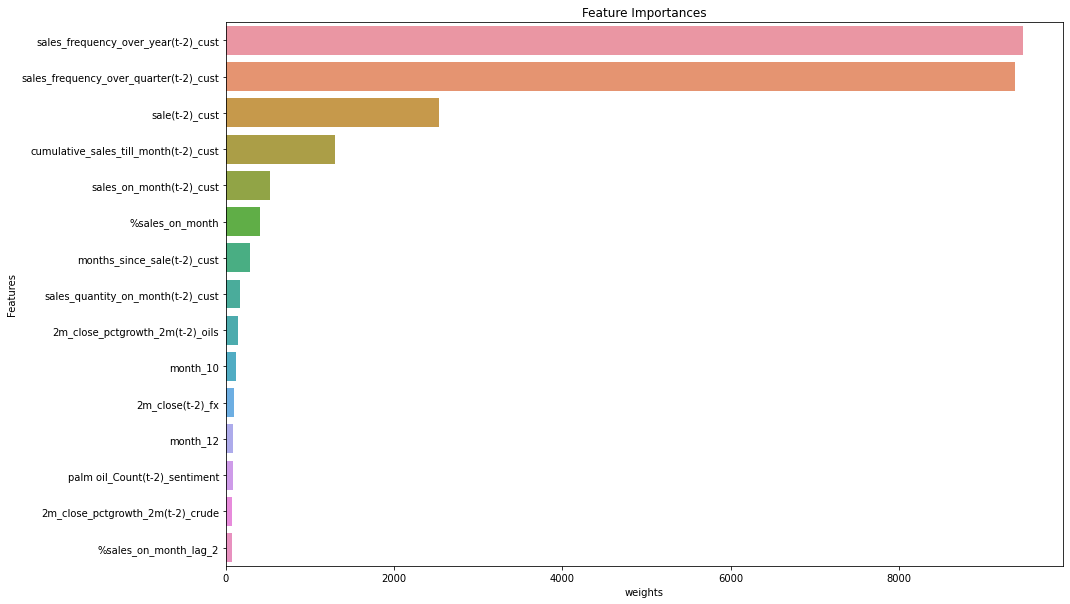

,weights
sales_frequency_over_year(t-2)_cust,9475.775067
sales_frequency_over_quarter(t-2)_cust,9376.763746
sale(t-2)_cust,2532.948572
cumulative_sales_till_month(t-2)_cust,1294.582305
sales_on_month(t-2)_cust,519.495049
%sales_on_month,410.072838
months_since_sale(t-2)_cust,281.699765
sales_quantity_on_month(t-2)_cust,161.102102
2m_close_pctgrowth_2m(t-2)_oils,141.008403
month_10,122.808245


In [71]:
feature_importance_with_pipe(pipeline = lgbm_selection, numeric_col = numeric_col, cat_col = cat_col)

### Check Robustness Over Time

Each model is saved in pickle file

In [72]:
def check_accuracy_dropoff_lgbm(name, tuned_model, X_train, y_train, X_test, y_test):

    ##### THIS IS THE ONLY PART THAT IS DIFFERENT ###########
    # Set up pipeline 
    numeric_col = X_train.select_dtypes(include=np.number).columns
    cat_col = X_train.select_dtypes(include='object').columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_col),
            ("cat", OneHotEncoder(sparse=False), cat_col),
        ]
        , remainder='passthrough'
    )
    
    # Set up pipeline
    pipeline = Pipeline([("preprocessor", preprocessor), # set threshold = 0 to turn off feature selection
                                  ('predict', tuned_model)], 
                               verbose=False)

    ##### THIS IS THE ONLY PART THAT IS DIFFERENT ###########
    
    fitted_model = fit_and_predict(model = pipeline, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    cross_validate_scores(name, fitted_model, X_train, y_train)

    return fitted_model

In [73]:
# Best
tuned_model = lgb.LGBMClassifier(n_estimators = 250,
                                max_depth = 2, 
                                max_bin = 4,
                                subsample = 0.85, 
                                colsample_bytree = 0.75,
                                scale_pos_weight = 2.2,
                                num_leaves = 80,
                                importance_type = 'gain',
                                random_state = random_state)

In [74]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 1, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lgbm_lag1 = check_accuracy_dropoff_lgbm(name = 'LGBMclf_1M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-1)_cust', 'purchases_on_month(t-1)_cust', 'purchase_quantity_on_month(t-1)_cust', 'cumulative_purchases_till_month(t-1)_cust', 'purchase_frequency(t-1)_cust', 'purchase_frequency_over_year(t-1)_cust', 'purchase_frequency_over_quarter(t-1)_cust', 'months_since_purchase(t-1)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [75]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 2, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lgbm_lag2 = check_accuracy_dropoff_lgbm(name = 'LGBMclf_2M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-2)_cust', 'purchases_on_month(t-2)_cust', 'purchase_quantity_on_month(t-2)_cust', 'cumulative_purchases_till_month(t-2)_cust', 'purchase_frequency(t-2)_cust', 'purchase_frequency_over_year(t-2)_cust', 'purchase_frequency_over_quarter(t-2)_cust', 'months_since_purchase(t-2)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [76]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 3, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lgbm_lag3 = check_accuracy_dropoff_lgbm(name = 'LGBMclf_3M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-3)_cust', 'purchases_on_month(t-3)_cust', 'purchase_quantity_on_month(t-3)_cust', 'cumulative_purchases_till_month(t-3)_cust', 'purchase_frequency(t-3)_cust', 'purchase_frequency_over_year(t-3)_cust', 'purchase_frequency_over_quarter(t-3)_cust', 'months_since_purchase(t-3)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [77]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 6, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

lgbm_lag6 = check_accuracy_dropoff_lgbm(name = 'LGBMclf_6M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-6)_cust', 'purchases_on_month(t-6)_cust', 'purchase_quantity_on_month(t-6)_cust', 'cumulative_purchases_till_month(t-6)_cust', 'purchase_frequency(t-6)_cust', 'purchase_frequency_over_year(t-6)_cust', 'purchase_frequency_over_quarter(t-6)_cust', 'months_since_purchase(t-6)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

## 3.3 Random Forest

### Check Impact of Different Steps

In [87]:
rf_pipe = Pipeline([("preprocessor", preprocessor),
                    ('oversample', SMOTETomek()), 
                    ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), 
                    ('predict', RandomForestClassifier())], 
                   verbose=10)

model = fit_and_predict(model = rf_pipe, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 4) Processing oversample, total=  11.5s
[Pipeline] . (step 3 of 4) Processing feature_selection, total=   4.0s
[Pipeline] ........... (step 4 of 4) Processing predict, total=   4.4s
Train f1 score:  0.8692602040816326
Train precision:  0.8731582319026265
Train recall:  0.8653968253968254
Test f1 score:  0.42018779342723006
Test precision:  0.39955357142857145
Test recall:  0.4430693069306931


In [88]:
# Try with no SMOTE
# Tuning class weight can help RF wihout having to do smote which is super slow
rf_pipe = Pipeline([("preprocessor", preprocessor),
                    #('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), 
                    ('predict', RandomForestClassifier(n_estimators=100, max_depth = 6, class_weight = {0:1, 1:3}))], 
                   verbose=10)

model = fit_and_predict(model = rf_pipe, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing predict, total=   0.9s
Train f1 score:  0.51952770208901
Train precision:  0.4965277777777778
Train recall:  0.5447619047619048
Test f1 score:  0.4782608695652174
Test precision:  0.4669811320754717
Test recall:  0.4900990099009901


### Tune Random Forest

In [89]:
# Without feature selection
# Do not re-run
# Best params: {'preprocessor__num': StandardScaler(), 'classifier__n_estimators': 200, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 6, 'classifier__max_depth': 8, 'classifier__class_weight': {0: 1, 1: 3}}
# Best mean CV score: 0.5576069501939982
# Train score:  0.6008759668250861
# Test score:  0.5623632385120348

rf_pipe = Pipeline([("preprocessor", preprocessor),
                    ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), 
                    ('classifier', RandomForestClassifier())], 
                   verbose=False)

param_grid = [
    {
        'preprocessor__num':[StandardScaler(),RobustScaler()],
        "classifier__n_estimators": range(50, 500, 50), # Important
        "classifier__max_depth": range(2,20,2),
        'classifier__min_samples_leaf': range(0, 10, 2),
        'classifier__min_samples_split': range(0, 10, 2),
        'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}]
    },
]

search = random_search_pipe(model_pipe = rf_pipe, grid = param_grid, X_train = X_train, y_train = y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START classifier__class_weight={0: 1, 1: 1}, classifier__max_depth=14, classifier__min_samples_leaf=4, classifier__min_samples_split=0, classifier__n_estimators=300, preprocessor__num=StandardScaler()
[CV 1/3; 1/200] END classifier__class_weight={0: 1, 1: 1}, classifier__max_depth=14, classifier__min_samples_leaf=4, classifier__min_samples_split=0, classifier__n_estimators=300, preprocessor__num=StandardScaler();, score=nan total time=   1.3s
[CV 2/3; 1/200] START classifier__class_weight={0: 1, 1: 1}, classifier__max_depth=14, classifier__min_samples_leaf=4, classifier__min_samples_split=0, classifier__n_estimators=300, preprocessor__num=StandardScaler()
[CV 2/3; 1/200] END classifier__class_weight={0: 1, 1: 1}, classifier__max_depth=14, classifier__min_samples_leaf=4, classifier__min_samples_split=0, classifier__n_estimators=300, preprocessor__num=StandardScaler();, score=nan total time=   1.3s
[CV 3/3; 1/

### Best Random Forest

In [90]:
pipe_rf_tuned = Pipeline([("preprocessor", preprocessor),
                          ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), 
                          ('predict', RandomForestClassifier(n_estimators=400, 
                                                       max_depth = 4, 
                                                       min_samples_leaf = 2,
                                                       min_samples_split = 6,
                                                       class_weight = {0:1, 1:4},
                                                       random_state =random_state))], 
                   verbose=10)

best_rf = fit_and_predict(model = pipe_rf_tuned, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   3.6s
[Pipeline] ........... (step 3 of 3) Processing predict, total=   4.3s
Train f1 score:  0.4938453963564747
Train precision:  0.40329714515480497
Train recall:  0.6368253968253968
Test f1 score:  0.4965920155793574
Test precision:  0.40930979133226325
Test recall:  0.6311881188118812


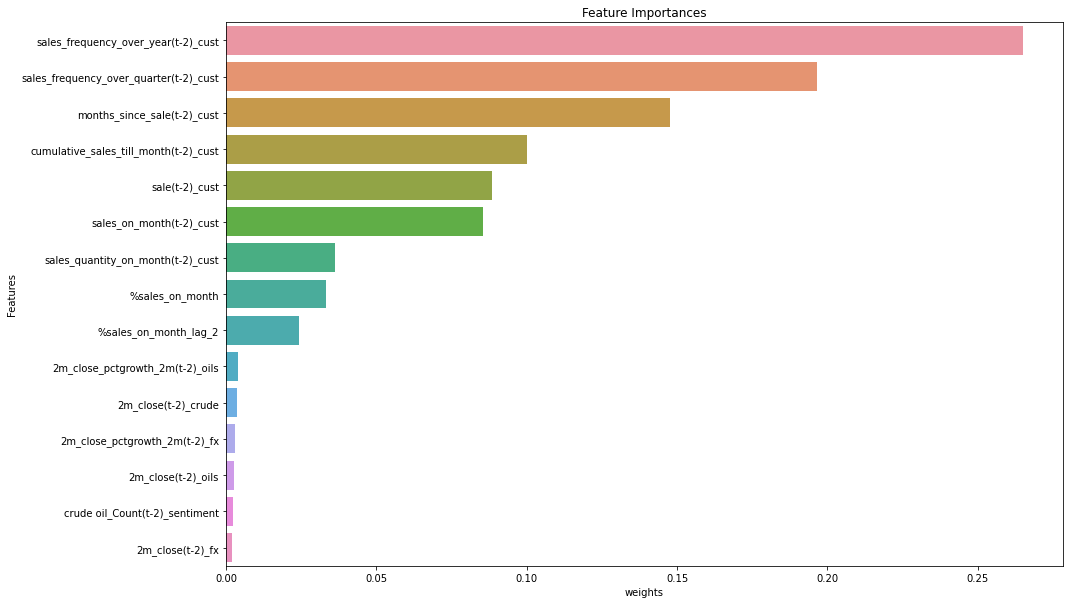

,weights
sales_frequency_over_year(t-2)_cust,0.265057
sales_frequency_over_quarter(t-2)_cust,0.196641
months_since_sale(t-2)_cust,0.147641
cumulative_sales_till_month(t-2)_cust,0.100144
sale(t-2)_cust,0.088441
sales_on_month(t-2)_cust,0.085353
sales_quantity_on_month(t-2)_cust,0.036312
%sales_on_month,0.033120
%sales_on_month_lag_2,0.024223
2m_close_pctgrowth_2m(t-2)_oils,0.004149


In [91]:
feature_importance_with_pipe(pipeline = best_rf, numeric_col = numeric_col, cat_col = cat_col)

### Check Robustness Over Time

In [93]:
def check_accuracy_dropoff_rf(name, tuned_model, X_train, y_train, X_test, y_test):

    ##### THIS IS THE ONLY PART THAT IS DIFFERENT ###########
    # Set up pipeline 
    numeric_col = X_train.select_dtypes(include=np.number).columns
    cat_col = X_train.select_dtypes(include='object').columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_col),
            ("cat", OneHotEncoder(sparse=False), cat_col),
        ]
        , remainder='passthrough'
    )
    
    # Set up pipeline
    pipeline = Pipeline([("preprocessor", preprocessor),
                         ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold='median')), 
                         ('predict', tuned_model)], 
                        verbose=False)

    ##### THIS IS THE ONLY PART THAT IS DIFFERENT ###########
    
    fitted_model = fit_and_predict(model = pipeline, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    cross_validate_scores(name, fitted_model, X_train, y_train)

    return fitted_model

In [94]:
# Best
tuned_model = RandomForestClassifier(n_estimators=400, 
                                   max_depth = 4, 
                                   min_samples_leaf = 2,
                                   min_samples_split = 6,
                                   class_weight = {0:1, 1:4},
                                   random_state = random_state)

In [95]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 1, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

rf_lag1 = check_accuracy_dropoff_rf(name = 'RF_1M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

# Test f1 score:  0.5673003802281369
# Test precision:  0.5130674002751031
# Test recall:  0.6343537414965986
# ----RF_1M_Lag----
# Mean 3-fold cross val f1 score: 0.564843
# Mean 3-fold cross val precision: 0.508889
# Mean 3-fold cross val recall: 0.634776

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-1)_cust', 'purchases_on_month(t-1)_cust', 'purchase_quantity_on_month(t-1)_cust', 'cumulative_purchases_till_month(t-1)_cust', 'purchase_frequency(t-1)_cust', 'purchase_frequency_over_year(t-1)_cust', 'purchase_frequency_over_quarter(t-1)_cust', 'months_since_purchase(t-1)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [96]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 2, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

rf_lag2 = check_accuracy_dropoff_rf(name = 'RF_2M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-2)_cust', 'purchases_on_month(t-2)_cust', 'purchase_quantity_on_month(t-2)_cust', 'cumulative_purchases_till_month(t-2)_cust', 'purchase_frequency(t-2)_cust', 'purchase_frequency_over_year(t-2)_cust', 'purchase_frequency_over_quarter(t-2)_cust', 'months_since_purchase(t-2)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [97]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 3, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

rf_lag3 = check_accuracy_dropoff_rf(name = 'RF_3M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-3)_cust', 'purchases_on_month(t-3)_cust', 'purchase_quantity_on_month(t-3)_cust', 'cumulative_purchases_till_month(t-3)_cust', 'purchase_frequency(t-3)_cust', 'purchase_frequency_over_year(t-3)_cust', 'purchase_frequency_over_quarter(t-3)_cust', 'months_since_purchase(t-3)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [98]:
X_train, X_test, y_train, y_test = get_train_test_split(lag = 6, # change this
                                                        oil = oil, 
                                                        oil_file = oil_file, 
                                                        first_date =first_date, 
                                                        last_date = last_date,
                                                        ema_lookback = ema_lookback, 
                                                        pct_lookback = pct_lookback, 
                                                        adv_months_list = adv_months_list, 
                                                        cols_to_keep = sentiment_cols)

rf_lag6 = check_accuracy_dropoff_rf(name = 'RF_6M_Lag', 
                                        tuned_model = tuned_model,
                                       X_train = X_train,
                                       X_test = X_test,
                                       y_train = y_train,
                                       y_test = y_test)

Generating Customer DF...
Length of Customer DF: 19200
Lagging customer variables...
Lagged customer df of len 19200 has been created containing 400 unique customers.
Generating FUTURES DFs...
Lagging variables...
Created oils_df of length 48, crude_df of length 48 and fx_df of length 48.
You are getting sentiment for: ['crude oil', 'crude oil_Count', 'palm oil', 'palm oil_Count']
Created sentiment df of length 51
Remove customer columns: ['%purchase_on_month', '%purchase_on_month_lag_2', 'purchase(t-6)_cust', 'purchases_on_month(t-6)_cust', 'purchase_quantity_on_month(t-6)_cust', 'cumulative_purchases_till_month(t-6)_cust', 'purchase_frequency(t-6)_cust', 'purchase_frequency_over_year(t-6)_cust', 'purchase_frequency_over_quarter(t-6)_cust', 'months_since_purchase(t-6)_cust', 'purchase', 'purchases_on_month', 'counter_party_code', 'commodity']
Created combined_df for predection of len 19200 and first date 2018-01-31 00:00:00
Length before dropping na (lag rows): 19200
Length after drop

In [101]:
# # Save best model in local
import pickle

# LightGBM
names = ['lgbm_palmkernel_1M', 'lgbm_palmkernel_2M', 'lgbm_palmkernel_3M', 'lgbm_palmkernel_6M']
models = [lgbm_lag1, lgbm_lag2, lgbm_lag3, lgbm_lag6]

# LogReg
# names = ['lr_palmkernel_1M', 'lr_palmkernel_2M', 'lr_palmkernel_3M', 'lr_palmkernel_6M']
# models = [lr_lag1, lr_lag2, lr_lag3, lr_lag6]

# RF
# names = ['rf_palmkernel_1M', 'rf_palmkernel_2M', 'rf_palmkernel_3M', 'rf_palmkernel_6M']
# models = [rf_lag1, rf_lag2, rf_lag3, rf_lag6]

for file, model in zip(names, models):
    filename = '{}.sav'.format(file)
    pickle.dump(model, open(filename, 'wb'))

# loaded_model = pickle.load(open(filename, 'rb'))

# filename = 'best_model/lgbm_palm.sav'
# lgbm_best = pickle.load(open(filename, 'rb'))